# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ 

Структура:
- Validation, Validationannot - изображения и маски из валидационного сета в формате Camvid 1.0
- Train, Trainannot - соответственно из трейн сета

Доп файлы:
- label_colors.txt - цвета классов масок сегментаций из трейн и тест сета в формате Camvid 1.0

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

In [2]:
seed = 40
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [3]:
DATSET_NAME = "U-Net"

X_TRAIN_DIR = f"{DATSET_NAME}/images"
Y_TRAIN_DIR = f"{DATSET_NAME}/masks"

X_VALID_DIR = f"{DATSET_NAME}/images"
Y_VALID_DIR = f"{DATSET_NAME}/masks"

X_TEST_DIR = f"{DATSET_NAME}/images"
Y_TEST_DIR = f"{DATSET_NAME}/masks"

LABEL_COLORS_FILE = f"{DATSET_NAME}/classes.txt" #Пример: 0 0 0 human \n 255 40 40 car

Задание констант:

In [4]:
CLASSES = [
    "background",
    "human"
]

COLORS_IMSHOW = {
        "background" : np.array([255, 255, 255]),
        "human" : np.array([0, 0, 0])
}

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 4
BATCH_SIZE = 16

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Вспомогательные функции

В данном примере в датасете на входе имеется трехканальная (так как 3 класса) фотка где в кажом пикселе стоит во всех каналах 0 кроме одного в котором 1. Тем самым кодируется класс конкретного пикселя в маске

In [37]:
def create_annotations_of_no_calsses_images(images_folder, annotations_folder):
    image_files = os.listdir(images_folder)
    for image_file in image_files:
        image_path = os.path.join(images_folder, image_file)
        annotation_path = os.path.join(annotations_folder, f"{os.path.splitext(image_file)[0]}.png")        
        img = Image.open(image_path)
        width, height = img.size
        
        if not os.path.exists(annotation_path):
            img = Image.new('RGB', (width, height), color='black')
            img.save(annotation_path)

def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ Осуществляет перевод трехканальной маски (число каналов сколько классов) в трехканальное 
    изображение где будет расцветка как зададим в словаре colors_imshow для классов """

    # colors_imshow = {
    #         "background" : np.array([255, 255, 255]),
    #         "human" : np.array([0, 0, 0])
    # }

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):


        
#Сюда нам нужно подать маску из двух слоев (не (R, G, B), а (background, human))


        
        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        # Заодно осуществляет подсчет процента каждого класса (сумма пикселей на общее число)
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size
        
        sc_mask += np.multiply.outer(singlechannel_mask > 0, COLORS_IMSHOW[cls]).astype(np.uint8)
        

    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title

def visualize_with_image(image, mc_mask, class_id):
    mc_mask = mc_mask.transpose(2, 0, 1)
    mask = mc_mask[class_id]
    color_overlay = np.zeros_like(image)
    #print(color_overlay.shape)
    color_overlay[mask > 0] = [COLORS_IMSHOW[CLASSES[class_id]]]
    result = cv2.addWeighted(image, 1, color_overlay, 0.7, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

# Dataloader

Использовать если есть фотки на которых вся разметка классом background:

In [6]:
#create_annotations_of_no_calsses_images(X_TRAIN_DIR, Y_TRAIN_DIR)
#create_annotations_of_no_calsses_images(X_VALID_DIR, Y_VALID_DIR)
#create_annotations_of_no_calsses_images(X_TEST_DIR, Y_TEST_DIR)

In [7]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = glob(f"{images_dir}/*")
        self.masks_paths = glob(f"{masks_dir}/*")

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([255, 255, 255], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()] #Попробуй расширить диапазон        
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        #print(self.masks_paths[i])
        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

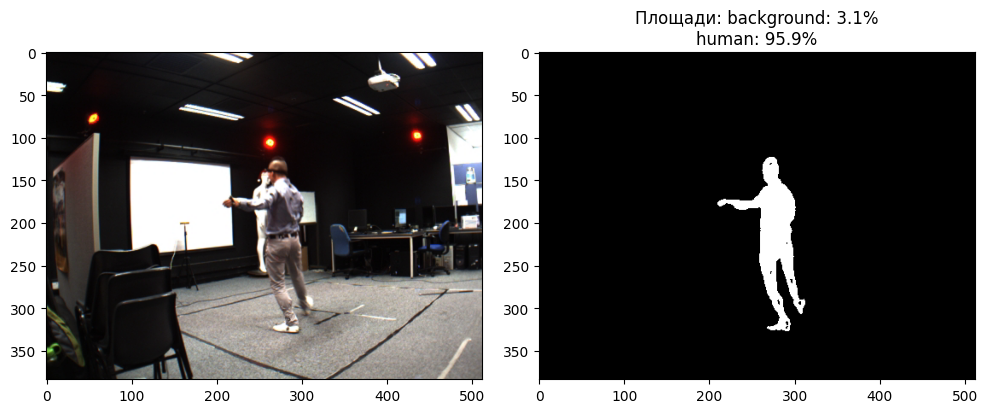

In [8]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image, mask)

In [9]:
visual_image = visualize_with_image(image, mask, 0)
print(visual_image)
# cv2.imshow('2', visual_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[[[ 39  63  43]
  [  9  33  13]
  [  0   0  44]
  ...
  [ 18  17  19]
  [ 17  13  18]
  [ 15  11  16]]

 [[  0  18   0]
  [  0  17   0]
  [  0   0  45]
  ...
  [ 17  16  18]
  [ 18  14  19]
  [ 15  11  16]]

 [[ 10   7  10]
  [ 11   8  11]
  [ 10   9  11]
  ...
  [ 16  16  16]
  [ 19  15  16]
  [ 19  15  16]]

 ...

 [[  5   3   4]
  [  5   3   4]
  [  4   4   4]
  ...
  [108 111 113]
  [110 113 115]
  [109 112 114]]

 [[  5   5   5]
  [  5   5   5]
  [  3   3   3]
  ...
  [117 119 123]
  [114 120 121]
  [108 114 115]]

 [[  6   6   6]
  [  5   5   5]
  [  4   4   4]
  ...
  [121 123 127]
  [114 120 121]
  [110 116 117]]]


# Augmentations

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на train:

C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:6: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),
D:\Programs\Python\Lib\site-packages\albumentations\augmentations\blur\functional.py:231: UserWarning: blur_limit: Invalid kernel size range (1, 3). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)
C:

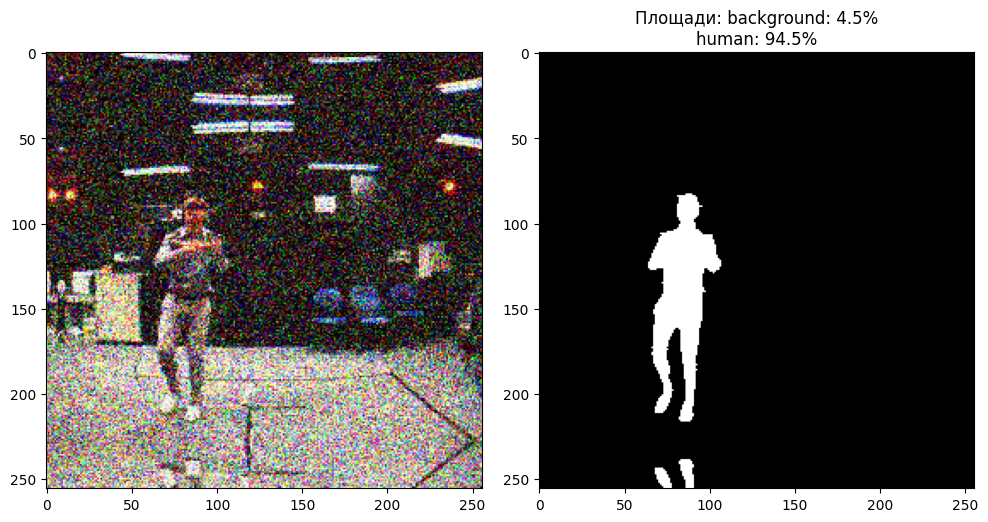

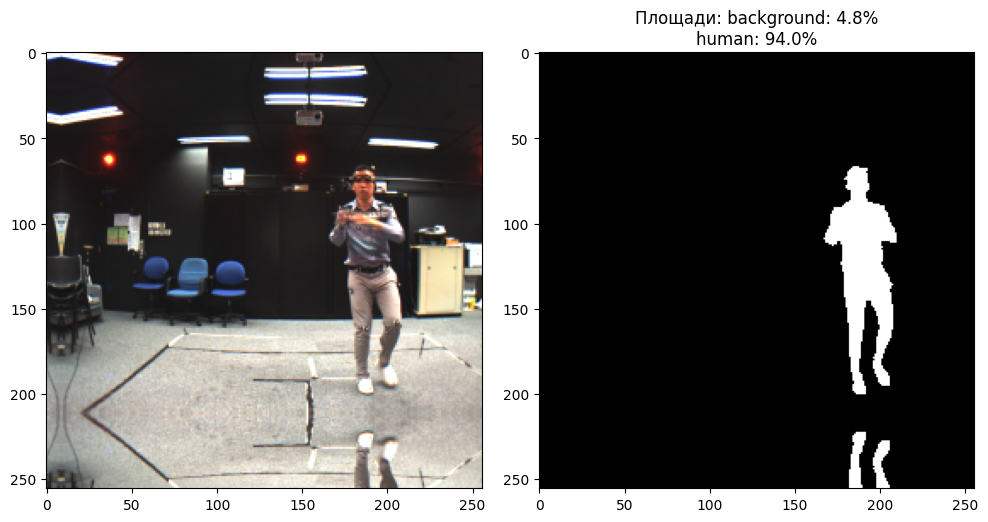

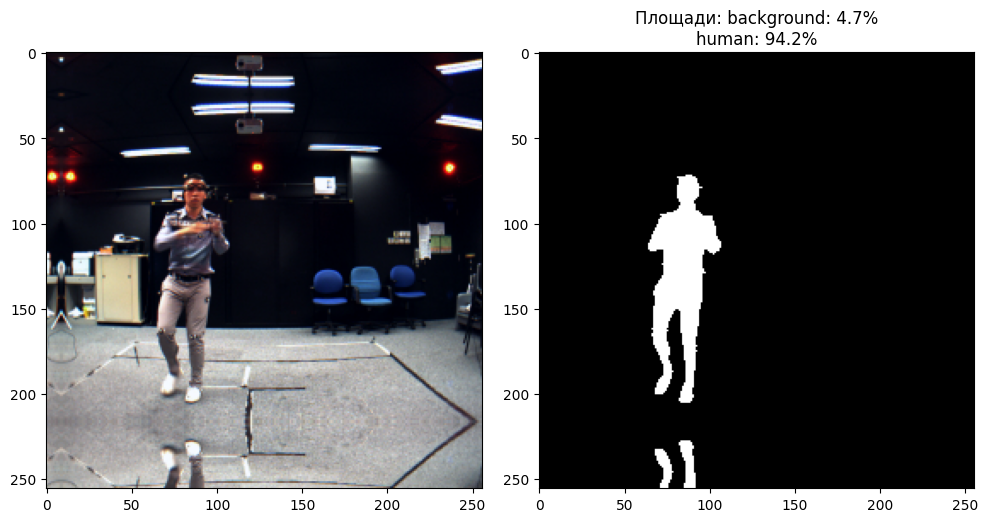

In [11]:
augmented_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

Пример аугментаций на val:

C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:31: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:32: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:33: UserWarning: Argument(s) 'always_apply' are not valid for transform CenterCrop
  albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]


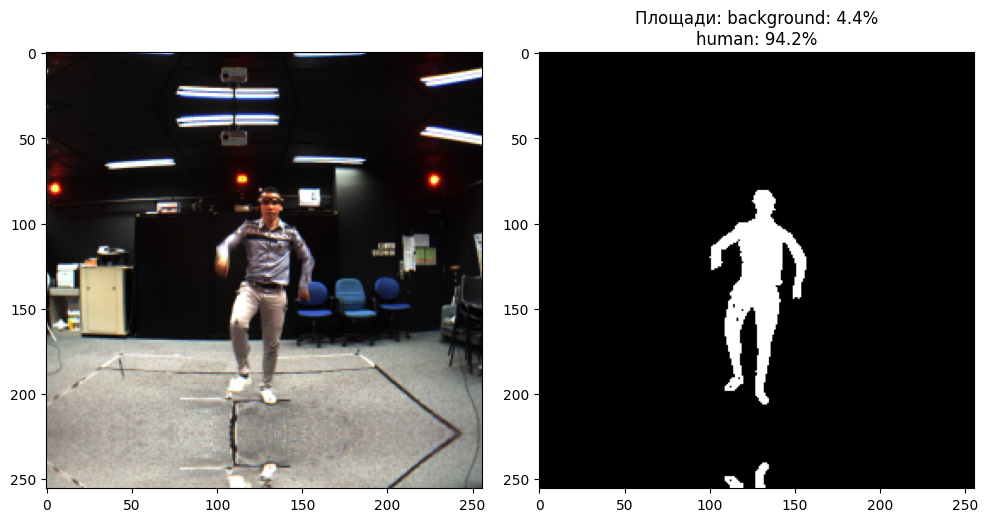

In [12]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create model and train

In [13]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [14]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [15]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # -- классика деление на 255

In [16]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x0000022969B4E3E0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [17]:
train_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:6: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3191627627.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\3

In [18]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [19]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Обучение:

In [20]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        #torch.save(model, 'models/best_model_new.pth')
        # Save the model with JIT
        # Create a tensor with the specified dimensions
        #trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        # Trace the model using the example input
        # traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        # torch.jit.save(traced_model, 'models/best_model_new.pt')

        traced_model = torch.jit.script(model)
        traced_model.save('My_U-Net_models/model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF
        
traced_model = torch.jit.script(model)
traced_model.save('My_U-Net_models/last_model_new.pt')


Epoch: 0
valid: 100%|█████████████| 1192/1192 [00:35<00:00, 33.88it/s, dice_loss - 0.06586, fscore - 0.9823, iou_score - 0.9677]
Model saved!
LR: 0.0005

Epoch: 1
valid: 100%|█████████████| 1192/1192 [00:27<00:00, 42.67it/s, dice_loss - 0.02364, fscore - 0.9875, iou_score - 0.9777]
Model saved!
LR: 0.0005

Epoch: 2
valid: 100%|██████████████| 1192/1192 [00:28<00:00, 41.31it/s, dice_loss - 0.0164, fscore - 0.9891, iou_score - 0.9809]
Model saved!
LR: 0.0005

Epoch: 3
valid: 100%|█████████████| 1192/1192 [00:27<00:00, 42.84it/s, dice_loss - 0.01404, fscore - 0.9895, iou_score - 0.9817]
Model saved!
LR: 0.0005


Оценка обучения:

NameError: name 'loss_logs' is not defined

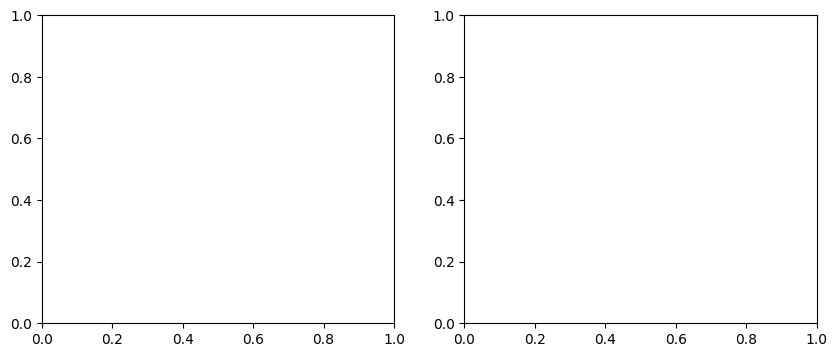

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

# Test best saved model

In [21]:
model = torch.jit.load("My_U-Net_models/last_model_new.pt")

In [22]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [23]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR, 
    Y_TEST_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=model,#best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\2975994607.py:2: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\2975994607.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
C:\Users\vipvo\AppData\Local\Temp\ipykernel_12400\2975994607.py:4: UserWarning: Argument(s) 'always_apply' are not valid for transform CenterCrop
  albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]


valid: 100%|██████████████| 1192/1192 [00:38<00:00, 30.87it/s, dice_loss - 0.1571, fscore - 0.8459, iou_score - 0.7343]


# Visualize predictions

In [24]:
#                                                          ПОЙМИ ЭТОТ БЛОК КОДА

def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, COLORS_IMSHOW[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    # Invert normalization
    img = img * np.array(std) + np.array(mean)
    return img


def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    # размер img: H, W, CHANNEL
    # размер mask_gt, mask_pred: H, W, значения - range(len(CLASSES)
    _, axes = plt.subplots(1, 3, figsize=(10, 5))
    img = img.transpose(1, 2, 0)
    if normalized:
        # Reverse the normalization to get the unnormalized image
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    axes[0].imshow(img)

    mask_gt, square_ratios = _colorize_mask(mask_gt)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[1].imshow(mask_gt, cmap="twilight")
    axes[1].set_title(f"GT маска\n" + title)

    mask_pred, square_ratios = _colorize_mask(mask_pred)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[2].imshow(mask_pred, cmap="twilight")
    axes[2].set_title(f"PRED маска\n" + title)

    plt.tight_layout()
    plt.show()

(256, 256) (3, 256, 256) (2, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..1.0000000236034394].


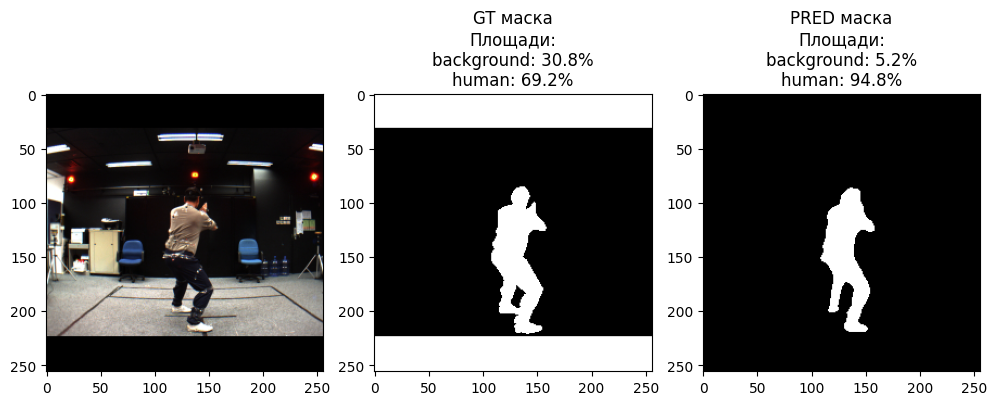

In [25]:
for i in range(1):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    #pr_mask = best_model(x_tensor)
    pr_mask = model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

---

In [75]:
#ДОДЕЛАЙ ЧТОБЫ НА КАМЕРЕ НОРМ РАБОТАЛО + ДООБУЧИ НЕМНОГО МОДЕЛЬ
def cam_vizualize(model):
    cap = cv2.VideoCapture(0)
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)#Как это работает???????????????
    # Проверьте, успешно ли открыт захват
    if not cap.isOpened():
        print("Не удалось открыть веб-камеру")
        exit()
    
    while True:
        # Чтение кадра из веб-камеры
        ret, frame = cap.read()
        frame = cv2.resize(frame, (256, 256))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        # Если кадр успешно прочитан, ret будет True
        if not ret:
            print("Не удалось получить кадр")
            break

        frame = preprocessing_fn(frame)
        frame_tensor = np.transpose(frame, (2, 0, 1))
        frame_tensor =  torch.tensor(frame_tensor, dtype = torch.float32).unsqueeze(0)
        frame_tensor = frame_tensor.to(DEVICE)
        #print(frame_tensor.shape)
        #break
        # Отображение кадра
        #cv2.imshow('Webcam', frame)
        
        pred = model(frame_tensor)
        pred = pred.squeeze()
        
        pred = pred.to('cpu')
        pred = pred.detach().numpy().astype(np.uint8)
        pred = _convert_multichannel2singlechannel(pred)[0]
        #print(pred.shape, pred)
        cv2.imshow('mask', pred)
        #print(f'pred: {pred.shape}')
        frame_int = frame.astype(np.uint8)
        #print(f'frame: {frame_int.shape}')
        result = visualize_with_image(frame_int, pred, 0)
        cv2.imshow('U-Net', result)
    
        # Если нажата клавиша 'q', выход из цикла
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Освобождение ресурсов
    cap.release()
    cv2.destroyAllWindows()

In [76]:
cam_vizualize(model)

In [74]:
# img, test_mask = test_dataset[4]
# test_mask = _convert_multichannel2singlechannel(test_mask)[0]
img = cv2.imread('U-Net/ded2.jpg')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
img = cv2.resize(img, (256, 256))
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocessing_fn(img)
img = img.transpose(2, 0, 1)
test_img = torch.tensor(img, dtype = torch.float32).unsqueeze(0)
test_img = test_img.to(DEVICE)
print(test_img.shape)
pred = model(test_img)
pred = pred.squeeze()      
pred = pred.to('cpu')
pred = pred.detach().numpy().astype(np.uint8)
pred = _convert_multichannel2singlechannel(pred)[0]
#cv2.imshow('image', img)
cv2.imshow('pred', pred)
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([1, 3, 256, 256])
